In [8]:
import netCDF4 as nc
import netCDF4 as Dataset
import math
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

In [9]:
h = nc.Dataset('Data/S5P_OFFL_L1C_SIFTRS_20240206T123417_20240206T123957_32732_93_010100_20250228T104502_irr.nc')
africa = h.groups['africa']
h1 = nc.Dataset('Data/S5P_OFFL_L1C_SIFTRS_20240206T105346_20240206T105827_32731_93_010100_20250228T104244_irr.nc')
africa1 = h1.groups['africa']

In [10]:
#Remove all scanlines where there is one groundpixel that has a cloud in that combination/ coordinate 
scanline_nocloud = []
for n in range(406):
    if (africa.variables['CloudFraction'][0,n,223]<0.4).all():
            if (africa.variables["Reflectance_err"][0,n,223]<80).all():
                if (africa.variables["SZA"][0,n,223]<75).all():
                    scanline_nocloud.append(n)

#remove Reflectance_err>80 and SZA<75

#Remove all scanlines where there is one groundpixel that has a cloud in that combination/ coordinate 
scanline_nocloud1 = []
for n in range(336):
    if (africa1.variables['CloudFraction'][0,n,223]<0.4).all():
            if (africa1.variables["Reflectance_err"][0,n,223]<80).all():
                if (africa1.variables["SZA"][0,n,223]<75).all():
                     if (africa1.variables["SurfaceClassification"][0,n,223] == 148).all():
                        scanline_nocloud1.append(n)


nocloud_value =scanline_nocloud #np.concatenate((scanline_nocloud, scanline_nocloud1), axis = 0)

In [11]:
#Fixing albedo 
import numpy.polynomial.polynomial as po
def indexate(wl, ranges):
    if isinstance(ranges[0], (int, float)):  # Single range
        start, end = ranges
        return np.where((wl >= start) & (wl <= end))[0]
    else:  # Multiple ranges
        indices = np.concatenate([np.where((wl >= start) & (wl <= end))[0] for start, end in ranges])
        return np.sort(indices)
        
ds = nc.Dataset("Data/wl_per_grpx_sahara_b.nc")
wl_per_gp_sahara_b = ds.variables["Ref_wl"][:]
wl_ground_pixel_224 = wl_per_gp_sahara_b[223, :]  # select ground pixel 224 (index 223)
wl = wl_ground_pixel_224 
retrievalWindow = (734, 758) # retrieval wavelength window [nm]
windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
sb_order = 5 # order of polynomial fit of surface reflectivity (barren)
ind    = indexate(wl, retrievalWindow)
ind_na = indexate(wl, windowsOfNoAbsorption)
ref_na = africa.variables["Reflectance"][0, :, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo = np.zeros((len(scanline_nocloud), 194))
for idx, i in enumerate(scanline_nocloud):
    poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo[idx, :] = surf_alb
ref_na1 = africa1.variables["Reflectance"][0, :, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo1 = np.zeros((len(scanline_nocloud1), 194))
for idx, i in enumerate(scanline_nocloud1):
    poly_sa = po.polyfit (wl[ind_na], ref_na1[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo1[idx, :] = surf_alb

albedo_value =surf_albedo # np.concatenate((surf_albedo, surf_albedo1), axis = 0)
    

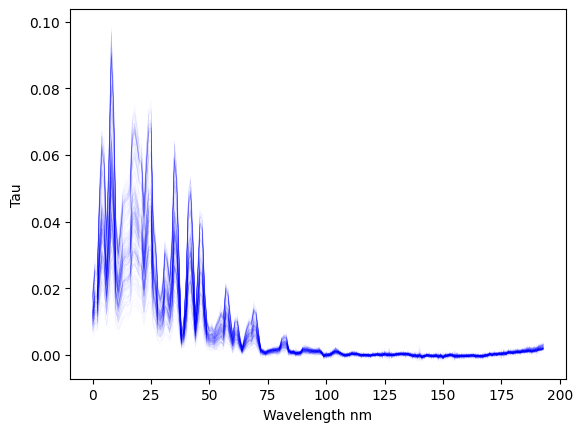

In [12]:
#Computing tau
mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,223]))
mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,223]))
mu_matrix = np.tile(mu[:, np.newaxis], 194)
mu_0_matrix = np.tile(mu_0[:, np.newaxis], 194)
reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 223, ind].data


mu1 = np.cos(np.radians(africa1.variables["VZA"][0,scanline_nocloud1,223]))
mu_01 = np.cos(np.radians(africa1.variables["SZA"][0,scanline_nocloud1,223]))
mu_matrix1 = np.tile(mu1[:, np.newaxis], 194)
mu_0_matrix1 = np.tile(mu_01[:, np.newaxis], 194)
reflectance_matrix1 = africa1.variables['Reflectance'][0, scanline_nocloud1, 223, ind].data

mu_value = mu_matrix # np.concatenate((mu_matrix, mu_matrix1), axis = 0)
mu_0_value = mu_0_matrix # np.concatenate((mu_0_matrix, mu_0_matrix1), axis = 0)
reflectance_value = reflectance_matrix #np.concatenate((reflectance_matrix, reflectance_matrix1), axis = 0)
angle_value = (mu_value + mu_0_value)/mu_value*mu_0_value
tau_value = -np.log(reflectance_value/albedo_value)/angle_value


for idx, i  in enumerate(nocloud_value):
    plt.plot(tau_value[idx],color='blue', alpha=0.1, linewidth=0.1)
    plt.xlabel("Wavelength nm")
    plt.ylabel("Tau")
plt.show()

In [13]:
#plt.plot(-(africa.variables["Reflectance"][0, scanline_nocloud, 224, ind] - surf_albedo)[0])

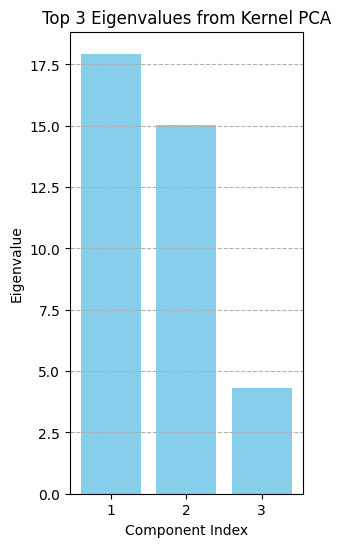

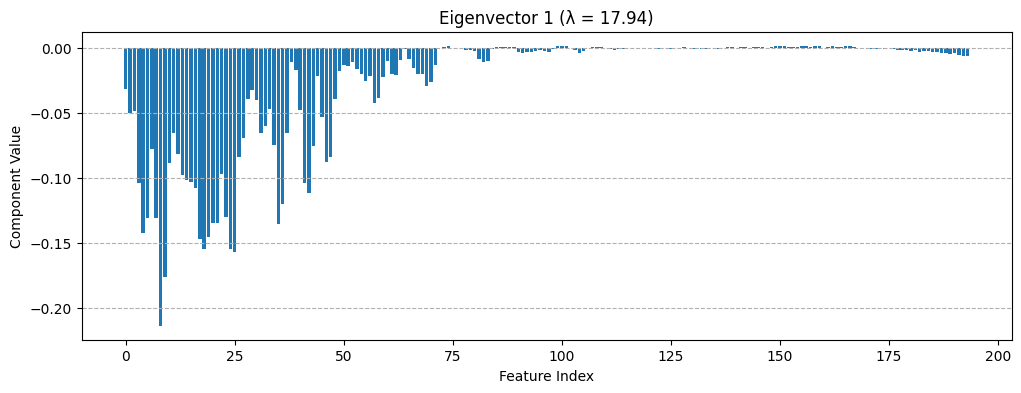

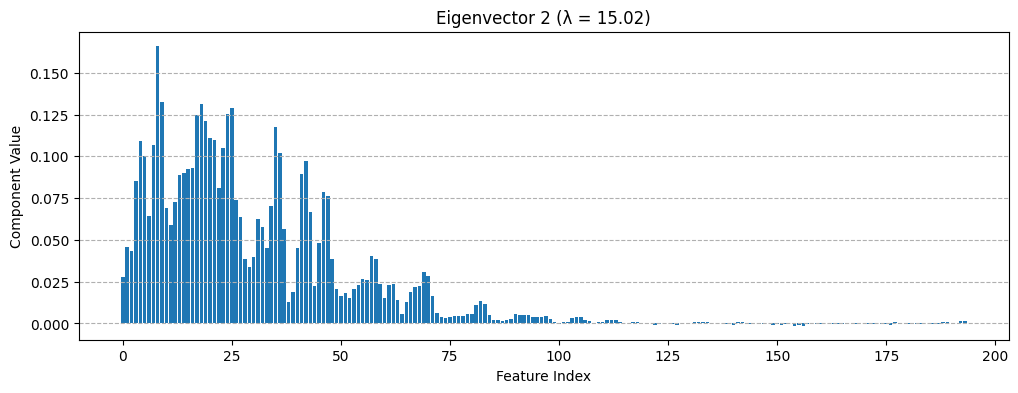

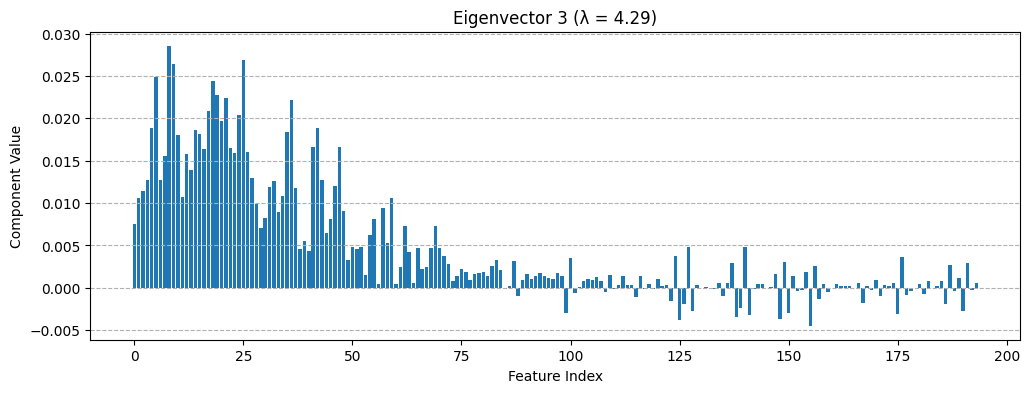

/var/folders/wj/pgnjjx3n5dg6p90187_803300000gn/T/ipykernel_82812/1573619731.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tau_reduced[:, 0], tau_reduced[:, 1], alpha=0.7, cmap="coolwarm")


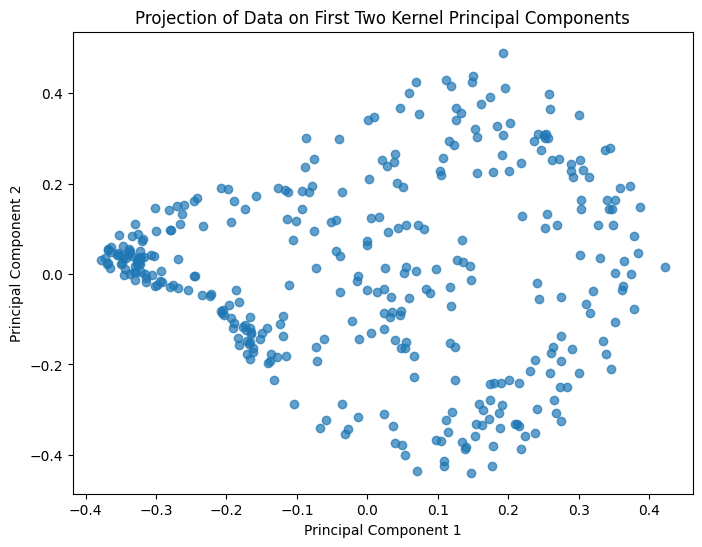

In [14]:
scaler = StandardScaler()
tau_scaled = scaler.fit_transform(tau_value)

# Apply Kernel PCA to reduce from 195 dimensions to, say, 10
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=0.01)  # Adjust gamma for RBF
tau_reduced = kpca.fit_transform(tau_scaled)
tau_centered = tau_value - np.mean(tau_value, axis=0)  # Center the data
eigenvectors = np.dot(tau_centered.T, kpca.eigenvectors_ ) # Shape (194, 195)

# Compute eigenvalues and eigenvectors in the original space
eigenvalues = kpca.eigenvalues_

# Sort eigenvalues in descending order and get top 10 indices
sorted_indices = np.argsort(eigenvalues)[::-1][:3]
top3_eigenvalues = eigenvalues[sorted_indices]

# Plot top 10 eigenvalues
plt.figure(figsize=(3, 6))
plt.bar(range(3), top3_eigenvalues, color='skyblue')
plt.title("Top 3 Eigenvalues from Kernel PCA")
plt.xlabel("Component Index")
plt.ylabel("Eigenvalue")
plt.xticks(range(3), range(1,4))
plt.grid(axis='y', linestyle='--')
plt.show()
components = []
# Plot the top 10 eigenvectors (as 194-dimensional vectors)
for i, idx in enumerate(sorted_indices):
    components.append(eigenvectors[:, idx])
    plt.figure(figsize=(12, 4))
    plt.bar(range(194), eigenvectors[:, idx])
    plt.title(f"Eigenvector {i+1} (λ = {eigenvalues[idx]:.2f})")
    plt.xlabel("Feature Index")
    plt.ylabel("Component Value")
    plt.grid(axis='y', linestyle='--')
    plt.show()
    
plt.figure(figsize=(8, 6))
plt.scatter(tau_reduced[:, 0], tau_reduced[:, 1], alpha=0.7, cmap="coolwarm")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Projection of Data on First Two Kernel Principal Components")
plt.show()

In [15]:
np.array(components).shape

(3, 194)

In [16]:
# # Data dimensions
# input_dim = tau_value.shape[1]  # 195
# encoding_dim = 10# latent dimension

# # Custom layer for tied weights
# class TiedTransposeDense(tf.keras.layers.Layer):
#     def __init__(self, tied_to_layer, activation=None, **kwargs):
#         super().__init__(**kwargs)
#         self.tied_to_layer = tied_to_layer
#         self.activation = tf.keras.activations.get(activation)
        
#     def build(self, input_shape):
#         self.bias = self.add_weight(name='bias', shape=(input_dim,))
#         super().build(input_shape)
        
#     def call(self, inputs):
#         # Get weights from encoder and transpose them
#         encoder_weights = tf.transpose(self.tied_to_layer.weights[0])
#         output = tf.matmul(inputs, encoder_weights) + self.bias
#         return self.activation(output)

# # Build model
# input_data = Input(shape=(input_dim,))
# encoder = Dense(encoding_dim, activation='linear', name='encoder')
# encoded = encoder(input_data)

# # Tied decoder
# decoded = TiedTransposeDense(tied_to_layer=encoder, activation='linear', name='decoder')(encoded)

# # Complete autoencoder
# autoencoder = Model(inputs=input_data, outputs=decoded)
# autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# # Train
# history = autoencoder.fit(
#     tau_value, tau_value,
#     epochs=500,
#     batch_size=32,
#     shuffle=True,
#     validation_split=0.1,
#     verbose=0
# )

# # Extract components
# encoder_model = Model(inputs=input_data, outputs=encoded)
# encoded_data = encoder_model.predict(tau)
# components = decoder.weights[0].numpy().T  # Shape: (10, 195)

# # Sort by explained variance
# latent_variances = np.var(encoded_data, axis=0)
# sorted_indices = np.argsort(latent_variances)[::-1]

# # Plot top components
# plt.figure(figsize=(15, 20))
# for i in range(min(encoding_dim, 5)):  # Plot up to 16 components
#     plt.subplot(4, 4, i+1)
#     plt.plot(components[sorted_indices[i]])
#     plt.title(f'Component {i+1}\nVariance: {latent_variances[sorted_indices[i]]/latent_variances.sum()*100:.1f}%')
#     plt.xlabel("Wavelength (nm)" if 'wl' in locals() else "Feature Index")
#     plt.grid(True)
# plt.tight_layout()
# plt.savefig("AE_tau")
# plt.show()

# autoencoder.summary()

In [17]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# # Load and preprocess data
# X = tau_value  # Replace with your data
# X = StandardScaler().fit_transform(X)  # Critical for stable training

# # Define a deeper autoencoder with ReLU
# latent_dim = 50  # Smaller than input (194) for compression
# input_dim = X.shape[1]

# # Encoder (nonlinear)
# encoder = Sequential([
#     Dense(128, activation='relu', input_shape=(input_dim,)),
#     Dense(64, activation='relu'),
#     Dense(latent_dim, activation='relu')  # Latent space
# ])

# # Decoder (nonlinear)
# decoder = Sequential([
#     Dense(64, activation='relu', input_shape=(latent_dim,)),
#     Dense(128, activation='relu'),
#     Dense(input_dim, activation='linear')  # Linear output for reconstruction
# ])

# autoencoder = Sequential([encoder, decoder])
# autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# # Train with early stopping
# from tensorflow.keras.callbacks import EarlyStopping
# history = autoencoder.fit(
#     X, X,
#     epochs=500,
#     batch_size=16,
#     validation_split=0.2,
#     callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
# )

# # Plot training history
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.legend()
# plt.title('Training History')
# plt.show()

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 1. Get the decoder weights (shape: [latent_dim, input_dim])
# decoder = autoencoder.layers[-1]
# decoder_weights = decoder.get_weights()[0]  # Shape (64, 194) if last hidden layer has 64 units

# # 2. Get latent representations
# latent_reps = encoder.predict(X)  # Shape (317, 50)

# # 3. Compute variance contribution per latent dimension
# component_variances = []
# for i in range(latent_dim):
#     # Create latent vectors where only component i is active
#     latent_input = np.zeros((1, latent_dim))
#     latent_input[0, i] = 1  # Activate only the i-th component
    
#     # Get corresponding output pattern
#     component_pattern = decoder.predict(latent_input)[0]
#     component_variances.append(np.var(component_pattern))

# # 4. Sort components by variance
# sorted_indices = np.argsort(component_variances)[::-1]
# top_components = decoder_weights[sorted_indices] # Sorted weight vectors

# # 5. Plot top components
# plt.figure(figsize=(15, 8))
# for i in range(10):
#     plt.subplot(2, 5, i+1)
#     plt.bar(range(input_dim), top_components[i])
#     plt.title(f"Component {i+1}\n(Var: {component_variances[sorted_indices[i]]:.2f}")
#     plt.xlabel("Feature Index")
# plt.tight_layout()
# plt.show()

In [19]:
##SIF-retrieval 

In [20]:
#SOLAR IRRADIANCE -- The same in all areas of the world 
irradiance_vector = africa.variables["irradiance"][223, ind]
#CONVERTING UNITS --- Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹
def convert_irradiance(irradiance_mol, wavelength_nm):
    """
    Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ (photon flux) to mW m⁻² nm⁻¹.

    Parameters:
        irradiance_mol (array-like): Irradiance in mol s⁻¹ m⁻² nm⁻¹
        wavelength_nm (array-like): Corresponding wavelengths in nm

    Returns:
        array: Irradiance in mW m⁻² nm⁻¹
    """
    # Constants
    h = 6.62607015e-34  # Planck constant (J·s)
    c = 2.99792458e8    # Speed of light (m/s)
    Na = 6.02214076e23  # Avogadro's number (photons/mol)

    wavelength_m = np.array(wavelength_nm) * 1e-9  # Convert nm to m
    photon_energy = h * c / wavelength_m           # Energy per photon (J)

    irradiance_watts = np.array(irradiance_mol) * Na * photon_energy  # W m⁻² nm⁻¹
    irradiance_mW = irradiance_watts * 1e3  # Convert W to mW

    return irradiance_mW
       
irradiance_value = convert_irradiance(irradiance_vector, wl[ind])

(3, 194)
Fitted parameters:
[-0.12016108  0.16947519  0.091907   -0.04957308]


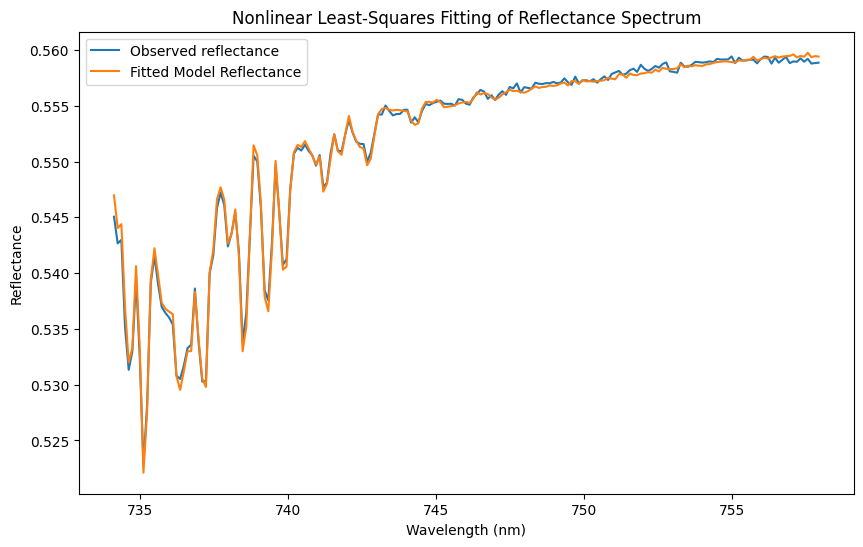

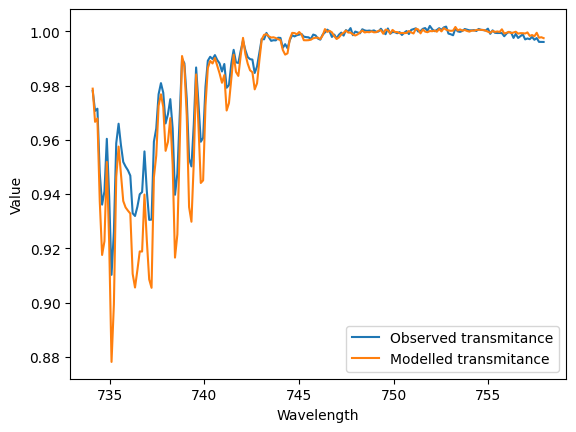

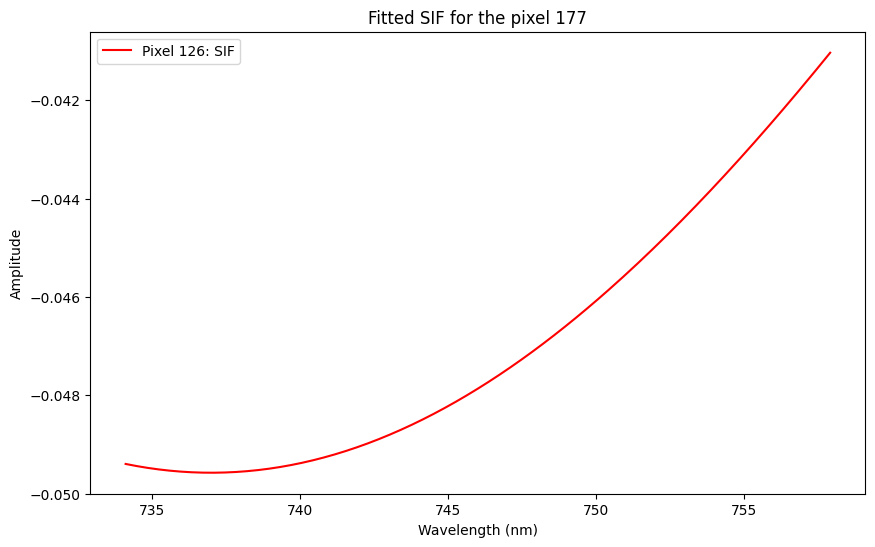

In [21]:
pixel_index = 100
reflectance_observed = reflectance_value[pixel_index]
f_matrix = np.array(components)
print(f_matrix.shape)
n = len(f_matrix)
def reflectance_model(lam, *params):

    # Unpack parameters
    b = np.array(params[0:n])
    c = params[n]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    # Baseline reflectance term:
    baseline = albedo_value[pixel_index] * np.exp(-attenuation)
    
    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_value[pixel_index]) / ((1 / mu_value[pixel_index]) + (1 / mu_0_value[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_value[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5] * n + [0.5]
# lower_bounds = [-np.inf] * n + [0]  # Allow b parameters to be anything, but c must be ≥ 0
# upper_bounds = [np.inf] * n + [np.inf]  # No upper bound on any parameter

# Fit the model to the observed reflectance
popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)#, bounds=(lower_bounds, upper_bounds),maxfev=10000)

print("Fitted parameters:")
print(popt)

# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
#plt.savefig("LM-fitting_AE")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_value) + np.reciprocal(mu_0_value))*tau_value)[pixel_index]
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[0:n])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_value[pixel_index]) + np.reciprocal(mu_0_value[pixel_index]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
#plt.savefig("LM_fit_transmitance_AE")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {nocloud_value[pixel_index]}: SIF", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted SIF for the pixel 177")
plt.legend()
#plt.savefig("LM_fit_SIF_AE")
plt.show()

Fitted parameters:
[ 2.00476726e-01  4.62977247e-04 -1.77402517e-01  9.15848990e-02
  1.81607092e-02  3.14367622e+00]


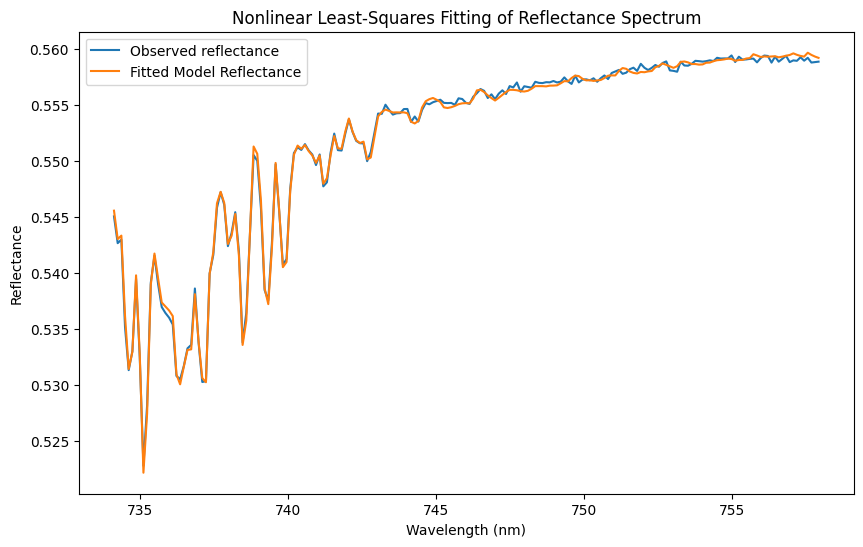

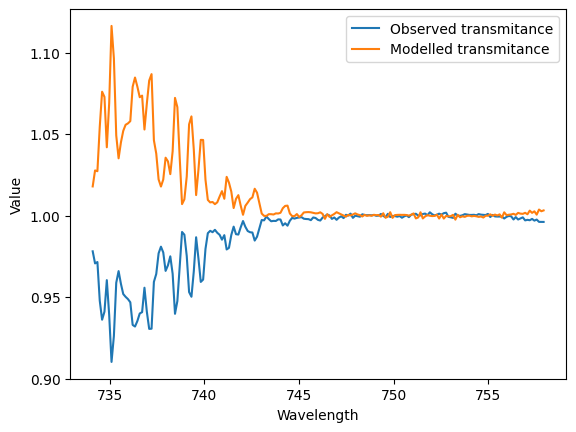

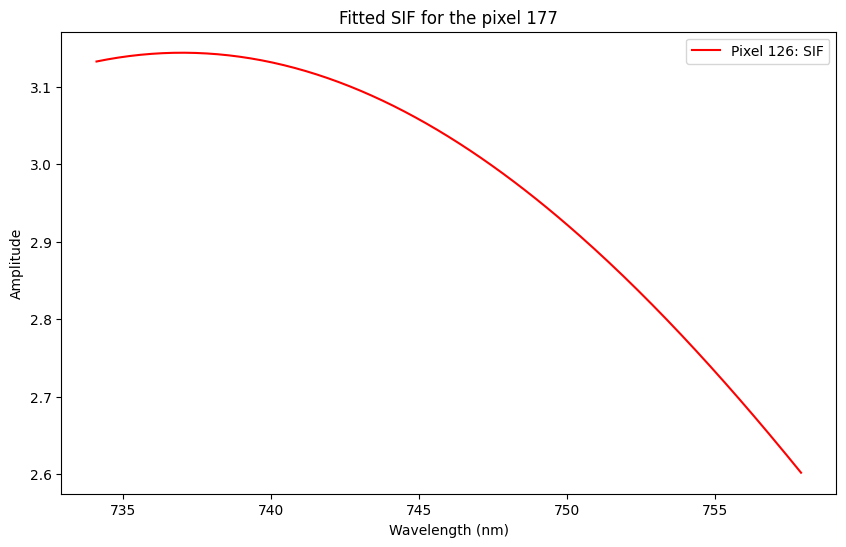

In [22]:
m = 2
pixel_index = 100
reflectance_observed = reflectance_value[pixel_index]
def reflectance_model(lam, *params):

    # Unpack parameters
    a = np.array(params[0:m]) 
    b = np.array(params[m:n+m])
    c = params[n+m]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    poly_term = sum(a[j] * lam**j for j in range(m))
    baseline = poly_term * np.exp(-attenuation)

    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_value[pixel_index]) / ((1 / mu_value[pixel_index]) + (1 / mu_0_value[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_value[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5]*m + [0.5] * n + [0.5]
# lower_bounds = [-np.inf] * (n+m) + [0]  # Allow b parameters to be anything, but c must be ≥ 0
# upper_bounds = [np.inf] * (n+m) + [np.inf]

popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds))

print("Fitted parameters:")
print(popt)

# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
#plt.savefig("LM-fitting_AE_A")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_value) + np.reciprocal(mu_0_value))*tau_value)[pixel_index]
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[0:n])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_value[pixel_index]) + np.reciprocal(mu_0_value[pixel_index]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
#plt.savefig("LM_fit_transmitance_AE")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {nocloud_value[pixel_index]}: SIF", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted SIF for the pixel 177")
plt.legend()
#plt.savefig("LM_fit_SIF_AE")
plt.show()

In [23]:
f_matrix = np.array(components)
print(f_matrix.shape)
n = len(f_matrix)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
SIF_values_per_scanline = []
for pixel_index, i in enumerate(nocloud_value):
    reflectance_observed = reflectance_value[pixel_index]
    def reflectance_model(lam, *params):

        # Unpack parameters
        a = np.array(params[0:m]) 
        b = np.array(params[m:n+m])
        c = params[n+m]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        poly_term = sum(a[j] * lam**j for j in range(m))
        baseline = poly_term * np.exp(-attenuation)
    
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_value[pixel_index]) / ((1 / mu_value[pixel_index]) + (1 / mu_0_value[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_value[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5]*m + [0.5] * n + [0.5]

    # lower_bounds = [-np.inf] * n + [0]  # Allow b parameters to be anything, but c must be ≥ 0
    # upper_bounds = [np.inf] * n + [np.inf]  # No upper bound on any parameter
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds),maxfev=10000)

    SIF_values_per_scanline.append(popt[-1])
    

(3, 194)


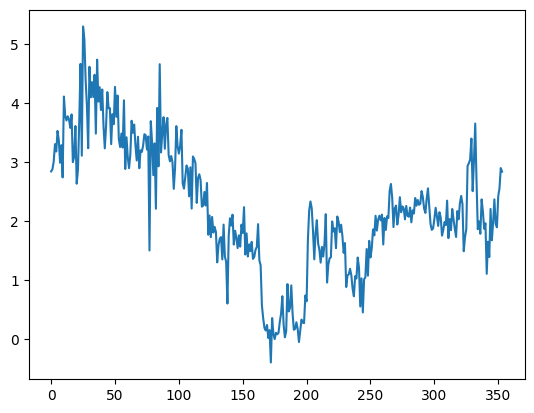

In [24]:
plt.plot(SIF_values_per_scanline)
plt.show()

In [25]:
f_matrix = np.array(components)
print(f_matrix.shape)
n = len(f_matrix)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
SIF_values_per_scanline = []
for pixel_index, i in enumerate(nocloud_value):
    reflectance_observed = reflectance_value[pixel_index]
    def reflectance_model(lam, *params):
    
        # Unpack parameters
        b = np.array(params[0:n])
        c = params[n]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        # Baseline reflectance term:
        baseline = albedo_value[pixel_index] * np.exp(-attenuation)
        
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_value[pixel_index]) / ((1 / mu_value[pixel_index]) + (1 / mu_0_value[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_value[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5] * n + [0.5]
    # lower_bounds = [-np.inf] * n + [0]  # Allow b parameters to be anything, but c must be ≥ 0
    # upper_bounds = [np.inf] * n + [np.inf]  # No upper bound on any parameter
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds),maxfev=10000)

    SIF_values_per_scanline.append(popt[-1])
   

(3, 194)


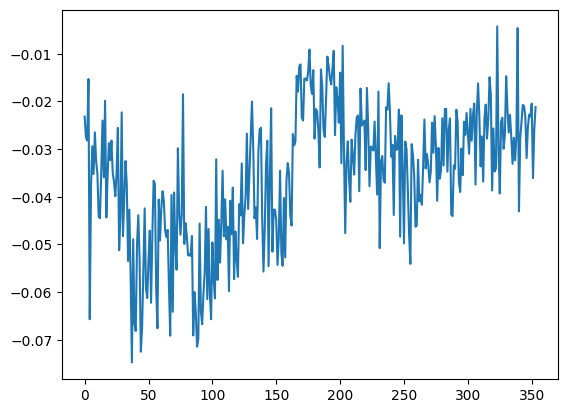

In [26]:
plt.plot(SIF_values_per_scanline)
plt.show()

In [27]:
h2 = nc.Dataset('sif_env/S5P_OFFL_L1C_SIFTRS_20240206T172817_20240206T173755_32735_93_010100_20250228T104827_irr.nc')
amazon = h2.groups['amazon']

FileNotFoundError: [Errno 2] No such file or directory: 'sif_env/S5P_OFFL_L1C_SIFTRS_20240206T172817_20240206T173755_32735_93_010100_20250228T104827_irr.nc'

In [ ]:
#Remove clouds
scanline_nocloud2 = []
for n in range(406):
    if (amazon.variables['CloudFraction'][0,n,223]<0.4).all():
            if (amazon.variables["Reflectance_err"][0,n,223]<80).all():
                if (amazon.variables["SZA"][0,n,223]<75).all():
                    scanline_nocloud2.append(n)
sc_nc2 = len(scanline_nocloud2)
#Fixing albedo 

ref_na2 = amazon.variables["Reflectance"][0, scanline_nocloud2, 223, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_alb2 = np.zeros((sc_nc2, 194))
for i in range(sc_nc2):
    poly_sa = po.polyfit (wl[ind_na], ref_na2[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_alb2[i, :] = surf_alb

#Computing tau
mu2 = np.cos(np.radians(amazon.variables["VZA"][0,scanline_nocloud2,223]))
mu_02 = np.cos(np.radians(amazon.variables["SZA"][0,scanline_nocloud2,223]))
mu_matrix2 = np.tile(mu2[:, np.newaxis], (1,194))
mu_0_matrix2 = np.tile(mu_02[:, np.newaxis],(1, 194))
reflectance_matrix2 = amazon.variables['Reflectance'][0, scanline_nocloud2, 223, ind]


tau2 = -np.log(reflectance_matrix2/surf_alb2)/ (np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))


In [ ]:
f_matrix = np.array(components)
print(f_matrix.shape)
n = len(f_matrix)
pixel_index = 100
SIF_values_per_scanline2 = []
for pixel_index, i in enumerate(scanline_nocloud2):
    reflectance_observed = amazon.variables['Reflectance'][0, i, 223,ind].data
    def reflectance_model(lam, *params):
    
        # Unpack parameters
        
        b = np.array(params[0:n])
        c = params[n]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        # Baseline reflectance term:
        baseline = surf_alb2[pixel_index] * np.exp(-attenuation)
        
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence
    
    # Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0] * n + [0]
    
    # Fit the model to the observed reflectance
    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)
    SIF_values_per_scanline2.append(popt[-1])
    
    if pixel_index == 100:
        print("Fitted parameters:")
        print(popt)
        
        # ---- Plot the results ----
        
        R_fit = reflectance_model(wl[ind], *popt)
        
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
        plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
        #plt.savefig("LM-fitting_AE_A")
        plt.legend()
        plt.show()
        
        #Plot transmittance observed and modelled
        transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2))*tau2)[100]
        # Extract the fitted PCA coefficients (b0 to b9)
        b_fit = np.array(popt[0:n])
        # Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
        attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)
        
        transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
        plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
        plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
        plt.xlabel('Wavelength')
        plt.ylabel('Value')
        plt.legend(loc="best")
        #plt.savefig("LM_fit_AE_transmitance_A")
        plt.show()
        # Pre-compute the Gaussian (same for every pixel if center and width are fixed)
        gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)
        
        # For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
        plt.figure(figsize=(10, 6))
        plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud2[100]}: c*Gaussian", color='red')
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Amplitude")
        plt.title("Fitted SIF for pixel 157")
        #plt.savefig("LM_fit_SIF_AE_A")
        plt.legend()
        plt.show()
plt.plot(SIF_values_per_scanline2)
plt.show()
print(np.mean(SIF_values_per_scanline2))  

In [ ]:
m = 2
def reflectance_model(lam, *params):

    # Unpack parameters
    a = np.array(params[0:m]) 
    b = np.array(params[m:n+m])
    c = params[n+m]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    poly_term = sum(a[j] * lam**j for j in range(m))
    baseline = poly_term * np.exp(-attenuation)

    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5]*m + [0.5] * n + [1]
# lower_bounds = [-np.inf] * (n+m) + [0]  # Allow b parameters to be anything, but c must be ≥ 0
# upper_bounds = [np.inf] * (n+m) + [np.inf]

popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0) #, bounds=(lower_bounds, upper_bounds))

print("Fitted parameters:")
print(popt)

# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
#plt.savefig("LM-fitting_AE_A")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*tau2[100])
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[m:n+m])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
#plt.savefig("LM_fit_AE_transmitance_A")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], popt[-1]*gaussian_full, label=f"Pixel {scanline_nocloud2[100]}: SIF Amplitude", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted ")
plt.legend()
#plt.savefig("LM_fit_SIF_AE_A")
plt.show()

In [ ]:
f_matrix = np.array(components)
print(f_matrix.shape)
n = len(f_matrix)
SIF_values_per_scanline2 = []
for pixel_index, i in enumerate(scanline_nocloud2):
    reflectance_observed = amazon.variables['Reflectance'][0, i, 223,ind].data
    m=2
    def reflectance_model(lam, *params):

        # Unpack parameters
        a = np.array(params[0:m]) 
        b = np.array(params[m:n+m])
        c = params[n+m]
        
        # Compute the weighted sum over the principal component spectral functions:
        attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
        
        poly_term = sum(a[j] * lam**j for j in range(m))
        baseline = poly_term * np.exp(-attenuation)
    
        # Gaussian term for the fluorescence component:
        gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
        
        # Geometric factor for the fluorescence attenuation:
        geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
        
        # Fluorescence (SIF) term:
        fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * irradiance_value)) * np.exp(-attenuation * geom_factor)
        
        # Total modeled reflectance:
        return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
    p0 = [0.5]*m + [0.5] * n + [0.5]

    popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0)

    SIF_values_per_scanline2.append(popt[-1])

In [ ]:

plt.plot(SIF_values_per_scanline2)
plt.show()
print(np.mean(SIF_values_per_scanline2))

In [ ]:
# print(irradiance_matrix2.shape, mu_0_matrix2.shape,diff2.shape, transmitance_modelled.shape, up_transmitance_modelled.shape,SIF.shape)
# plt.plot(SIF[1,1,:])
# plt.show()

In [ ]:
# SIF_va = np.stack(SIF)
# ground_pixel2 = africa2.variables['ground_pixel'][:]
# scanline2 = africa2.variables['scanline'][scanline_nocloud2]
# # Plot SIF over the Amazonas 448 groundpixels and 406 scanlines
# plt.imshow(SIF_va[:,:,100].data, origin='lower')
# plt.colorbar(label='SIF')
# plt.xlabel('Ground Pixel')
# plt.ylabel('Scanline')
# plt.title('SIF at First Spectral Channel at time 0')
# #plt.savefig('sif_colour.png')
# plt.show()
# SIF_va.shape

In [ ]:
# # Convert to PyTorch
# tau_centered_tensor = torch.from_numpy(tau_centered).float()

# # Create DataLoader
# train_dataset = TensorDataset(tau_centered_tensor, torch.zeros(len(scanline_nocloud)))
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # train_dataset = torch.tensor(tau[0:280], dtype=torch.float32)
# # test_dataset = torch.tensor(tau[280:317], dtype=torch.float32)
# # print("Train dataset shape:", train_dataset.shape)
# # print("Test dataset shape:", test_dataset.shape)
# # # create train and test dataloaders
# # batch_size = 100
# # train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle = True)
# # test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

# ##VISUALISE SOME TRANING DATA 
# tau_batch = next(iter(train_loader))

# # Select a sample to plot (first one in the batch)
# sample_index = 0
# tau_sample = tau_batch[sample_index]

# plt.plot(wl[ind],tau_sample.detach().T)
# plt.xlabel("Feature Index")
# plt.ylabel("Tau Value")
# plt.title(f"Batch {sample_index} from Training Set")
# plt.show()
# tau_sample.shape

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# # Define VAE model
# class VAE(nn.Module):
#     def __init__(self, input_dim=195, latent_dim=10):
#         super(VAE, self).__init__()

#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU()
#         )
#         self.fc_mu = nn.Linear(128, latent_dim)  # Mean
#         self.fc_logvar = nn.Linear(128, latent_dim)  # Log variance

#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, input_dim)
#         )
        
#     def encode(self, x):
#         h = self.encoder(x)
#         mu = self.fc_mu(h)
#         log_var = self.fc_logvar(h)
#         return mu, log_var

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z):
#         return self.decoder(z)

#     def forward(self, x):
#         h = self.encoder(x)
#         mu = self.fc_mu(h)
#         logvar = self.fc_logvar(h)
#         z = self.reparameterize(mu, logvar)
#         x_hat = self.decoder(z)
#         return x_hat, mu, logvar

# # Initialize model, optimizer, and loss function
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = VAE(input_dim=195, latent_dim=10).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # Loss function
# def loss_function(x, x_hat, mean, log_var):
#     reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')  # Use MSE for continuous data
#     KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
#     return reproduction_loss + KLD

# # Training function
# def train(model, optimizer, epochs, device):
#     model.train()
#     for epoch in range(epochs):
#         overall_loss = 0
#         for batch_idx, x in enumerate(train_loader):  # Fix unpacking issue
#             x = x[0].to(device)  # Extract tensor from dataset

#             optimizer.zero_grad()
#             x_hat, mean, log_var = model(x)
#             loss = loss_function(x, x_hat, mean, log_var)
            
#             overall_loss += loss.item()
#             loss.backward()
#             optimizer.step()

#         if (epoch + 1) % 500 == 0:
#             print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {overall_loss / len(train_loader)}")

# # Train model
# train(model, optimizer, epochs=5000, device=device)


In [ ]:
# import matplotlib.pyplot as plt

# model.eval()
# with torch.no_grad():
#     for i, data in enumerate(test_loader):
#         data = data.to(device)
#         recon, _, _ = model(data)
        
#         # Number of samples to plot
#         num_samples = min(3, len(data))
        
#         fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
        
#         for j in range(num_samples):
#             axes[0, j].plot(data[j].cpu().numpy(), label='Original')
#             axes[0, j].set_title(f'Original Function {j+1}')
#             axes[0, j].legend()
            
#             axes[1, j].plot(recon[j].cpu().numpy(), label='Reconstructed', color='orange')
#             axes[1, j].set_title(f'Reconstructed Function {j+1}')
#             axes[1, j].legend()
        
#         plt.tight_layout()
#         plt.show()
        
#         # Break after the first batch
#         break
# # tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# # latent_tsne = tsne.fit_transform(latent_np)

# # plt.figure(figsize=(8,6))
# # plt.scatter(latent_tsne[:,0], latent_tsne[:,1], alpha=0.7)
# # plt.xlabel("t-SNE Dimension 1")
# # plt.ylabel("t-SNE Dimension 2")
# # plt.title("Latent Space Visualization (t-SNE)")
# # plt.show()
